<a href="https://colab.research.google.com/github/hzchzc123123/CTR/blob/main/movie_data_preprocess_and_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torchkeras

In [ ]:

import numpy as np
import pandas as pd
import heapq

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

from collections import Counter,OrderedDict
from tqdm import tqdm
from itertools import chain
import os,sys,time
from accelerate import Accelerator
from copy import deepcopy

import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchkeras import summary, KerasModel
from torchkeras.metrics import AUC


import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


数据导入以及删除一些类似于网站这种显然没用的特征，特征值初步处理

In [ ]:
dataset_dir = "/content/drive/MyDrive/CRT/Neural CF/NeuralCF/archive/"
credits = pd.read_csv(dataset_dir + 'credits.csv')
keywords = pd.read_csv(dataset_dir + 'keywords.csv')
movies = pd.read_csv(dataset_dir + 'movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [ ]:
df.head(5)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


将一些包含了很多信息的单元格特征简化（提取名字）或者分开

In [ ]:
def get_text(text, obj='name'): #返回以name为键下的值
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df.drop('original_title', axis=1, inplace=True)
df.drop('overview', axis=1, inplace=True)
df.drop('tagline', axis=1, inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df['genres']

0         Animation, Comedy, Family
1        Adventure, Fantasy, Family
2                   Romance, Comedy
3            Comedy, Drama, Romance
4                            Comedy
                    ...            
45553        Drama, Action, Romance
45554                         Drama
45555       Action, Drama, Thriller
45556                              
45557                              
Name: genres, Length: 45558, dtype: object

In [ ]:
df.head(5)

,adult,budget,genres,id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,English,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,1995-12-15,262797249.0,104.0,"English, Français",6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,11.7129,"Warner Bros., Lancaster Gate",United States of America,1995-12-22,0.0,101.0,English,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,English,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,1995-02-10,76578911.0,106.0,English,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')
df =df.sort_values(by=['id'], ascending=[True])

In [ ]:
df.head(3)

,adult,budget,genres,id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors
4353,False,0.0,"Drama, Crime",2,fi,3.860491,"Villealfa Filmproduction Oy, Finnish Film Foun...",Finland,1988-10-21,0.0,69.0,"suomi, Deutsch",7.1,44.0,"underdog, prison, factory worker, prisoner, he...","Aki Kaurismäki, Aki Kaurismäki, Timo Salminen,...","Taisto Olavi Kasurinen, Irmeli Katariina Pihla...","Turo Pajala, Susanna Haavisto, Matti Pellonpää..."
13015,False,0.0,"Drama, Comedy",3,fi,2.292110,Villealfa Filmproduction Oy,Finland,1986-10-16,0.0,76.0,"English, suomi, svenska",7.1,35.0,"salesclerk, helsinki, garbage, independent film","Aki Kaurismäki, Aki Kaurismäki, Timo Salminen,...","Nikander, Ilona Rajamäki, Melartin, Co-worker,...","Matti Pellonpää, Kati Outinen, Sakari Kuosmane..."
17,False,4000000.0,"Crime, Comedy",5,en,9.026586,"Miramax Films, A Band Apart",United States of America,1995-12-09,4300000.0,98.0,English,6.5,539.0,"hotel, new year's eve, witch, bet, hotel room,...","Combustible Edison, Gary Frutkoff, Lance Brown...","Ted the Bellhop, Man, Angela, Elspeth, Margare...","Tim Roth, Antonio Banderas, Jennifer Beals, Ma..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45558 entries, 4353 to 20237
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 45558 non-null  object        
 1   budget                45558 non-null  float64       
 2   genres                45558 non-null  object        
 3   id                    45558 non-null  int64         
 4   original_language     45558 non-null  object        
 5   popularity            45558 non-null  float64       
 6   production_companies  45558 non-null  object        
 7   production_countries  45558 non-null  object        
 8   release_date          45558 non-null  datetime64[ns]
 9   revenue               45558 non-null  float64       
 10  runtime               45558 non-null  float64       
 11  spoken_languages      45558 non-null  object        
 12  vote_average          45558 non-null  float64       
 13  vote_count   

In [ ]:
df.nunique()

adult                       2
budget                   1205
genres                   4045
id                      44404
original_language          90
popularity              42908
production_companies    22401
production_countries     2366
release_date            17184
revenue                  6845
runtime                   353
spoken_languages         1835
vote_average               92
vote_count               1820
keywords                25853
crew                    42158
characters              39400
actors                  41786
dtype: int64

In [ ]:
df[['vote_count','vote_average','revenue','runtime','budget','popularity']].describe()

,vote_count,vote_average,revenue,runtime,budget,popularity
count,45558.000000,45558.000000,4.555800e+04,45558.000000,4.555800e+04,45558.000000
mean,110.504280,5.637115,1.128389e+07,95.017472,4.257162e+06,2.949126
std,491.833183,1.897338,6.452507e+07,37.526643,1.746352e+07,6.007230
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,3.000000,5.000000,0.000000e+00,85.000000,0.000000e+00,0.402940
50%,10.000000,6.000000,0.000000e+00,95.000000,0.000000e+00,1.150270
75%,35.000000,6.800000,0.000000e+00,107.000000,0.000000e+00,3.743562
max,14075.000000,10.000000,2.787965e+09,1256.000000,3.800000e+08,547.488298


# Rating data

In [ ]:
ratings_df = pd.read_csv(dataset_dir + 'ratings.csv')
ratings_df = ratings_df.head(1000000)

In [ ]:
ratings_df['userId'] = ratings_df['userId'].astype(np.int)
ratings_df['movieId'] = ratings_df['movieId'].astype(np.int)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [ ]:
ratings_df

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
999995,10183,380,4.0,833459432
999996,10183,381,4.0,833460156
999997,10183,410,3.0,833459559
999998,10183,415,4.0,833460564


In [ ]:
user_movie_counts = ratings_df.groupby('userId')['movieId'].count()
users_with_more_than_20_ratings = user_movie_counts[user_movie_counts > 20].index
filtered_ratings_df = ratings_df[ratings_df['userId'].isin(users_with_more_than_20_ratings)]
ratings_df = filtered_ratings_df
ratings_df


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
999995,10183,380,4.0,833459432
999996,10183,381,4.0,833460156
999997,10183,410,3.0,833459559
999998,10183,415,4.0,833460564


In [ ]:
train_ratings_df, test_ratings_df = train_test_split(ratings_df, test_size = 0.2, random_state=2020)
train_ratings_df = train_ratings_df.sort_values(
    by=['userId', 'timestamp'], ascending=[True, True])
test_ratings_df = test_ratings_df.sort_values(
    by=['userId', 'timestamp'], ascending=[True, True])
train_ratings_df

,userId,movieId,rating,timestamp
6,1,2762,4.5,1425941300
13,1,54503,3.5,1425941313
26,1,112552,5.0,1425941336
22,1,92439,5.0,1425941424
10,1,4878,5.0,1425941434
...,...,...,...,...
999990,10183,370,4.0,833460699
999989,10183,368,4.0,833460699
999999,10183,419,2.0,833461026
999994,10183,378,5.0,833461211


In [ ]:
test_ratings_df

,userId,movieId,rating,timestamp
23,1,96821,5.0,1425941382
11,1,5577,5.0,1425941397
16,1,68358,5.0,1425941464
15,1,59315,5.0,1425941502
7,1,2918,5.0,1425941593
...,...,...,...,...
999988,10183,367,3.0,833459760
999967,10183,256,4.0,833459760
999961,10183,207,4.0,833460205
999993,10183,377,5.0,833460368


In [ ]:
filtered_df = test_ratings_df[(test_ratings_df['rating'] >= 3) & (test_ratings_df['userId'] == 1)]
filtered_df

,userId,movieId,rating,timestamp
23,1,96821,5.0,1425941382
11,1,5577,5.0,1425941397
16,1,68358,5.0,1425941464
15,1,59315,5.0,1425941502
7,1,2918,5.0,1425941593


In [ ]:
def mark_last_timestamp(df):
    last = df[['userId', 'movieId']].groupby(
        by='userId', as_index=False).tail(1).copy()
    last['last'] = 1
    df = pd.merge(
        df, last, how='left',
        on=['userId', 'movieId'])
    df.loc[~df['last'].isnull(), 'last'] = 1
    df.loc[df['last'].isnull(), 'last'] = 0

    return df

In [ ]:
train_ratings_df = mark_last_timestamp(train_ratings_df)
test_ratings_df = mark_last_timestamp(test_ratings_df)

In [ ]:
train_ratings_df

,userId,movieId,rating,timestamp,last
0,1,2762,4.5,1425941300,0.0
1,1,54503,3.5,1425941313,0.0
2,1,112552,5.0,1425941336,0.0
3,1,92439,5.0,1425941424,0.0
4,1,4878,5.0,1425941434,0.0
...,...,...,...,...,...
762431,10183,370,4.0,833460699,0.0
762432,10183,368,4.0,833460699,0.0
762433,10183,419,2.0,833461026,0.0
762434,10183,378,5.0,833461211,0.0


In [ ]:
candidate_movie_ids = train_ratings_df.movieId.values
candidate_movie_ids

array([  2762,  54503, 112552, ...,    419,    378,    289])

In [ ]:
# slow implement
def neg_sampling(candidates, filters, length):
    max_len = len(candidates)

    res = []
    for i in range(length):
        while(1):
            c = candidates[np.random.randint(0, max_len)]
            if c not in filters:
                res.append(str(c))
                filters.add(c)
                break
    return res

In [ ]:
def get_hist_movie_ids(df, max_len=10):
    hist_movie_ids = list()
    neg_hist_movie_ids = list()
    for _, group in df.groupby(by='userId'):
        tmp_hist_movie_ids = list()
        for _, row in group.iterrows():
            # keep high rated movies
            if row['rating'] >= 3 and row['last'] == 0:
                tmp_hist_movie_ids.append(str(int(row['movieId'])))
        # keep latest high rated movies
        tmp_hist_movie_ids.reverse()
        tmp_hist_movie_ids = tmp_hist_movie_ids[:max_len]
        # revert to timestamp order
        tmp_hist_movie_ids.reverse()
        tmp_neg_hist_movie_ids = neg_sampling(
            candidate_movie_ids, set(hist_movie_ids), len(tmp_hist_movie_ids))
        hist_movie_ids.append('|'.join(tmp_hist_movie_ids))
        neg_hist_movie_ids.append('|'.join(tmp_neg_hist_movie_ids))
    return hist_movie_ids, neg_hist_movie_ids

In [ ]:
train_hist_movie_ids, train_neg_hist_movie_ids = get_hist_movie_ids(train_ratings_df)
test_hist_movie_ids, test_neg_hist_movie_ids = get_hist_movie_ids(test_ratings_df)

In [ ]:
train_ratings_df = train_ratings_df[train_ratings_df['last'] == 1]
train_ratings_df['histHighRatedMovieIds'] = train_hist_movie_ids
train_ratings_df['negHistMovieIds'] = train_neg_hist_movie_ids


test_ratings_df = test_ratings_df[test_ratings_df['last'] == 1]
test_ratings_df['histHighRatedMovieIds'] = test_hist_movie_ids
test_ratings_df['negHistMovieIds'] = test_neg_hist_movie_ids

In [ ]:
train_ratings_df = train_ratings_df.dropna(subset=['histHighRatedMovieIds'])
train_ratings_df = train_ratings_df[train_ratings_df['histHighRatedMovieIds'] != '']
train_ratings_df

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds
21,1,73017,5.0,1425942699,1.0,2959|99114|33794|58559|81834|69844|1968|4226|1...,5481|4367|6947|1228|88163|37733|103384|2617|86...
39,2,339,5.0,867041296,1.0,5|260|1356|762|58|1210|1233|605|1475|377,35836|1784|6254|55280|55555|72731|902|10|81932...
90,4,1422,4.0,1042674861,1.0,4226|4848|3476|5679|1909|1732|2875|1597|1645|4238,3302|5010|73|2428|3994|5991|3578|2657|23|1350
113,5,2163,2.0,949424522,1.0,750|1263|1945|1201|541|296|1225|1198|1254|1193,10|51927|4756|103141|3177|1385|288|1292|5309|261
158,7,2858,4.5,1486254186,1.0,80463|81834|88125|54272|98809|39183|8533|10692...,1580|319|1918|1291|3160|65682|7361|114066|4015...
...,...,...,...,...,...,...,...
762267,10175,6016,4.5,1237400939,1.0,2001|2002|2353|2058|1556|7458|3623|2694|49286|912,153|6953|6755|1290|2671|3998|1196|4765|246|6709
762343,10176,1206,5.0,974759603,1.0,3741|608|154|2351|919|3095|903|2488|2511|1193,500|2405|1407|111360|8910|593|1278|628|27032|521
762369,10180,8950,4.5,1304658981,1.0,2012|72167|3253|3254|60756|4878|58559|4022|353...,252|2991|143245|5388|2324|3681|1059|2995|4578|...
762388,10182,56949,4.0,1234189781,1.0,33880|45880|33145|44613|32289|8643|47382|58107...,1655|5944|88125|1231|367|4878|368|261|7361|1088


In [ ]:
test_ratings_df = test_ratings_df.dropna(subset=['histHighRatedMovieIds'])
test_ratings_df = test_ratings_df[test_ratings_df['histHighRatedMovieIds'] != '']
test_ratings_df

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds
4,1,2918,5.0,1425941593,1.0,96821|5577|68358|59315,7153|5010|1193|4016
8,2,64,4.0,867039612,1.0,79|628,39292|910
19,4,2338,2.0,1042674886,1.0,1221|1097|1431|2716|2805|3753|1617|648|1644,1028|5944|5377|2448|1374|3712|140|2861|110730
22,5,2877,1.0,949424482,1.0,1270|908,155288|288
30,7,69844,3.5,1486253817,1.0,318|2571|7153|116797|54503,55292|265|1732|7101|2360
...,...,...,...,...,...,...,...
190555,10175,3753,5.0,1205083030,1.0,1784|593|44555|293|8873|1923|1132|5459|8361|786,88744|2167|103042|47|743|4095|4874|688|2149|708
190579,10176,1235,4.0,974759631,1.0,1304|915|1361|1237|1221|1254|1945|527|2648|949,1291|5040|78499|57669|3897|1370|2712|4893|1252...
190588,10180,74458,4.5,1300668191,1.0,2145|2114|2447|318|2011|3275|1982,47610|3793|4862|1388|597|1982|6357
190593,10182,7169,5.0,1234189772,1.0,531|3969|8362|38388,3741|829|4855|832


In [ ]:
df = df.rename(columns={'id': 'movieId'})

In [ ]:
train_ratings_df = pd.merge(train_ratings_df, df, how='inner', on='movieId')
test_ratings_df = pd.merge(test_ratings_df, df, how='inner', on='movieId')

In [ ]:
train_ratings_df.head(3)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors
0,2,339,5.0,867041296,1.0,5|260|1356|762|58|1210|1233|605|1475|377,35836|1784|6254|55280|55555|72731|902|10|81932...,False,3500000.0,"Comedy, Drama",...,1991-10-03,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala..."
1,3911,339,3.0,843587274,1.0,593|356|292|434|110|10|480|185|208|589,1212|2161|1041|98961|223|6537|1124|3910|4886|3387,False,3500000.0,"Comedy, Drama",...,1991-10-03,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala..."
2,4004,339,5.0,829291099,1.0,477|261|282|329|296|312|294|270|553|381,79132|106918|1883|527|186|1517|158|2871|2891|589,False,3500000.0,"Comedy, Drama",...,1991-10-03,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala..."


In [ ]:
test_ratings_df.head(3)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors
0,2,64,4.0,867039612,1.0,79|628,39292|910,False,9285469.0,"Drama, Romance",...,2002-03-14,51001550.0,112.0,Español,7.5,273.0,"suicide, spain, rape, coma, bullfight, torera,...","Agustín Almodóvar, Pedro Almodóvar, Pedro Almo...","Alicia, Lydia, Benigno, Marco, Rosa, Katerina ...","Leonor Watling, Rosario Flores, Javier Cámara,..."
1,8,2022,3.0,1013444158,1.0,553|4366|3679|2985|1343|3146|3016|2334|318|968,4771|39449|39|5989|57669|2161|4941|838|80549|4621,False,50000000.0,"Comedy, Romance",...,2002-06-28,171269535.0,96.0,English,5.6,660.0,"love letter, new hampshire, ferrari, liar, cit...","Sid Ganis, Jack Giarraputo, Teddy Castellucci,...","Longfellow Deeds, Babe Bennett, Emilio Lopez, ...","Adam Sandler, Winona Ryder, John Turturro, All..."
2,12,3052,5.0,944342864,1.0,457|1704|535|1217|2064|1617|2302|1719|1357|1185,410|5446|3420|2687|87430|34|48394|4214|3257|4848,False,0.0,Comedy,...,1967-06-20,0.0,97.0,English,6.4,8.0,"holiday, california, beach, erotic movie, tiki...","Philip H. Lathrop, Martin Ransohoff, John Call...","Carlo Cofield, Laura, Malibu, Rod Prescott, Di...","Tony Curtis, Claudia Cardinale, Sharon Tate, R..."


In [ ]:
train_ratings_df['label'] = 0
train_ratings_df.loc[train_ratings_df['rating'] >= 3, 'label'] = 1
test_ratings_df['label'] = 0
test_ratings_df.loc[test_ratings_df['rating'] >= 3, 'label'] = 1

In [ ]:
train_ratings_df.head(3)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,label
0,2,339,5.0,867041296,1.0,5|260|1356|762|58|1210|1233|605|1475|377,35836|1784|6254|55280|55555|72731|902|10|81932...,False,3500000.0,"Comedy, Drama",...,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala...",1
1,3911,339,3.0,843587274,1.0,593|356|292|434|110|10|480|185|208|589,1212|2161|1041|98961|223|6537|1124|3910|4886|3387,False,3500000.0,"Comedy, Drama",...,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala...",1
2,4004,339,5.0,829291099,1.0,477|261|282|329|296|312|294|270|553|381,79132|106918|1883|527|186|1517|158|2871|2891|589,False,3500000.0,"Comedy, Drama",...,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala...",1


In [ ]:
train_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2684 entries, 0 to 2683
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   userId                 2684 non-null   int64         
 1   movieId                2684 non-null   int64         
 2   rating                 2684 non-null   float64       
 3   timestamp              2684 non-null   int64         
 4   last                   2684 non-null   float64       
 5   histHighRatedMovieIds  2684 non-null   object        
 6   negHistMovieIds        2684 non-null   object        
 7   adult                  2684 non-null   object        
 8   budget                 2684 non-null   float64       
 9   genres                 2684 non-null   object        
 10  original_language      2684 non-null   object        
 11  popularity             2684 non-null   float64       
 12  production_companies   2684 non-null   object        
 13  pro

In [ ]:
class CategoryEncoder(BaseEstimator, TransformerMixin):
    #离散变量encoder，类别数据（如文本或标签）转换为整数索引
    def __init__(self, min_cnt=5, word2idx=None, idx2word=None):
    #接受三个参数：min_cnt（词频阈值，默认为5），word2idx（单词到索引的映射），idx2word（索引到单词的映射）。#
        super().__init__()
        self.min_cnt = min_cnt
        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()

    def fit(self, x, y=None):
        if not self.word2idx:
            counter = Counter(np.asarray(x).ravel())
            # 统计数据 x 中每个元素的出现次数。.ravel()返回一个扁平化（一维化）的数组
            selected_terms = sorted(
                list(filter(lambda x: counter[x] >= self.min_cnt, counter)))
            #选择出现次数不少于 min_cnt 的元素。 左边筛选条件 右边筛选对象
            self.word2idx = dict(
                zip(selected_terms, range(1, len(selected_terms) + 1)))
            self.word2idx['__PAD__'] = 0
            #字典 pad：0 selectedterm从1开始，unknown设为结尾+1，即如果遇到一个不在字典中的术语，比如 'cherry'，在转换过程中它会被映射到索引结尾+1
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)

        if not self.idx2word:
            self.idx2word = {
                index: word for word, index in self.word2idx.items()}

        return self
        # return self链式调用：这使得你可以在一个连续的表达式中链接多个方法调用。例如，你可以在同一行中连续调用 fit 和 transform 方法：encoder.fit(X).transform(X)

    def transform(self, x):
        transformed_x = list()
        for term in np.asarray(x).ravel():
            try:
                transformed_x.append(self.word2idx[term])
            except KeyError: #访问键不存在，加个unknown到最后
                transformed_x.append(self.word2idx['__UNKNOWN__'])

        return np.asarray(transformed_x, dtype=np.int64)

    def dimension(self):
        return len(self.word2idx)

In [ ]:
class SequenceEncoder(BaseEstimator, TransformerMixin):
    #文本序列转换为固定长度的整数索引序列
    def __init__(self, sep=' ', min_cnt=5, max_len=None,
                 word2idx=None, idx2word=None):
        super().__init__()
        self.sep = sep
        self.min_cnt = min_cnt
        self.max_len = max_len

        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()

    def fit(self, x, y=None):
        if not self.word2idx:#更新self.word2idx
            counter = Counter()

            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                #每个序列按照分隔符 self.sep 分割成单词列表
                counter.update(words)
                #update 方法用于向已存在的 Counter 字典对象添加或更新元素的计数
                max_len = max(max_len, len(words))
                #更新 max_len 为目前为止遇到的最长序列的单词数

            if self.max_len is None:
                self.max_len = max_len

            # drop rare words
            words = sorted(
                list(filter(lambda x: counter[x] >= self.min_cnt, counter)))

            self.word2idx = dict(zip(words, range(1, len(words) + 1)))
            self.word2idx['__PAD__'] = 0
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)

        if not self.idx2word:
            self.idx2word = {
                index: word for word, index in self.word2idx.items()}

        if not self.max_len:
            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                max_len = max(max_len, len(words))
            self.max_len = max_len

        return self

    def transform(self, x):
        transformed_x = list()

        for sequence in np.asarray(x).ravel():
            words = list()
            for word in sequence.split(self.sep):
                try:
                    words.append(self.word2idx[word])
                except KeyError:
                    words.append(self.word2idx['__UNKNOWN__'])

            transformed_x.append(
                np.asarray(words[0:self.max_len], dtype=np.int64))

        return np.asarray(transformed_x, dtype=object)

    def dimension(self):
        return len(self.word2idx)

    def max_length(self):
        return self.max_len

In [ ]:
dftrain = train_ratings_df
dfval = test_ratings_df

In [ ]:
dftrain.nunique()

userId                   2683
movieId                  1021
rating                     10
timestamp                2683
last                        1
histHighRatedMovieIds    2683
negHistMovieIds          2683
adult                       1
budget                    201
genres                    407
original_language          27
popularity               1021
production_companies      800
production_countries      172
release_date              961
revenue                   523
runtime                   133
spoken_languages          190
vote_average               53
vote_count                551
keywords                  943
crew                     1018
characters               1009
actors                   1014
label                       2
dtype: int64

In [ ]:
dftrain.head(1)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,label
0,2,339,5.0,867041296,1.0,5|260|1356|762|58|1210|1233|605|1475|377,35836|1784|6254|55280|55555|72731|902|10|81932...,False,3500000.0,"Comedy, Drama",...,2015810.0,129.0,"English, suomi, Français, Deutsch, Italiano",7.5,165.0,"paris, new york, taxi, megacity, rome, dialogu...","Jim Stark, Tom Waits, Jay Rabinowitz, Magda Ba...","Corky, Victoria Snelling, Rock Manager, Rock M...","Winona Ryder, Gena Rowlands, Lisanne Falk, Ala...",1


In [ ]:
for col in ["movieId","histHighRatedMovieIds","negHistMovieIds","genres"]:
    dftrain[col] = dftrain[col].astype(str)
    dfval[col] = dfval[col].astype(str)

num_features = ['budget','popularity','revenue','runtime','vote_count','vote_average']
cat_features = ['original_language', 'movieId', 'adult']#类别特征
seq_features = ['genres', 'histHighRatedMovieIds', 'negHistMovieIds','spoken_languages','keywords','crew','characters','actors', 'production_companies','production_countries']
#序列特征
for column in seq_features:
    dftrain[column] = dftrain[column].str.replace(',', '|')

In [ ]:
dftrain.head(1)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,label
0,2,339,5.0,867041296,1.0,5|260|1356|762|58|1210|1233|605|1475|377,35836|1784|6254|55280|55555|72731|902|10|81932...,False,3500000.0,Comedy| Drama,...,2015810.0,129.0,English| suomi| Français| Deutsch| Italiano,7.5,165.0,paris| new york| taxi| megacity| rome| dialogu...,Jim Stark| Tom Waits| Jay Rabinowitz| Magda Ba...,Corky| Victoria Snelling| Rock Manager| Rock M...,Winona Ryder| Gena Rowlands| Lisanne Falk| Ala...,1


In [ ]:
num_pipe = Pipeline(steps = [('impute',SimpleImputer()),('quantile',QuantileTransformer())])
#处理数值特征的管道 num_pipe。这个管道首先使用 SimpleImputer 填充缺失值，然后使用 QuantileTransformer 进行量化转换，使特征分布更加均匀或正态分布

encoders = {}

print("preprocess number features...")
dftrain[num_features] = num_pipe.fit_transform(dftrain[num_features]).astype(np.float32)
dfval[num_features] = num_pipe.transform(dfval[num_features]).astype(np.float32)
#fit_transform 在训练数据上计算年龄的最小值和最大值，并使用这些值来缩放训练数据。
#transform 在测试数据上使用相同的最小值和最大值来缩放数据，确保训练数据和测试数据的缩放方式一致。
#换句话来说 val上面的最大最小值还是用的train上的，即没有出现新的fit

print("preprocess category features...")
for col in tqdm(cat_features):#tqdm 是一个进度条库，用于显示处理进度
    encoders[col] = CategoryEncoder(min_cnt=5) #实例化，这个类里面定义了fit和transform
    dftrain[col]  = encoders[col].fit_transform(dftrain[col])
    dfval[col] =  encoders[col].transform(dfval[col])


print("preprocess sequence features...")
for col in tqdm(seq_features):
    encoders[col] = SequenceEncoder(sep="|",min_cnt=5)
    dftrain[col]  = encoders[col].fit_transform(dftrain[col])
    dfval[col] =  encoders[col].transform(dfval[col])

preprocess number features...
preprocess category features...


100%|██████████| 3/3 [00:00<00:00, 143.26it/s]


preprocess sequence features...


100%|██████████| 10/10 [00:00<00:00, 14.36it/s]


In [ ]:
dftrain.head(3)

,userId,movieId,rating,timestamp,last,histHighRatedMovieIds,negHistMovieIds,adult,budget,genres,...,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,label
0,2,69,5.0,867041296,1.0,"[907, 507, 193, 1163, 991, 112, 131, 1028, 130...","[799, 325, 1481, 1118, 1481, 1481, 1431, 2, 14...",1,0.564565,"[25, 8]",...,0.485986,0.846847,"[31, 17, 7, 4, 8]",0.781281,0.480981,"[1668, 983, 1399, 882, 1194, 380, 1044, 1400, ...","[5155, 4811, 2169, 3060, 816, 4771, 279, 2311,...","[3663, 3427, 2829, 2830, 2831, 3563, 154, 497,...","[4296, 1251, 2376, 45, 206, 1312, 3394, 3241, ...",1
1,3911,69,3.0,843587274,1.0,"[1007, 711, 580, 818, 60, 2, 873, 324, 386, 1001]","[117, 432, 24, 1476, 442, 1239, 1481, 862, 101...",1,0.564565,"[25, 8]",...,0.485986,0.846847,"[31, 17, 7, 4, 8]",0.781281,0.480981,"[1668, 983, 1399, 882, 1194, 380, 1044, 1400, ...","[5155, 4811, 2169, 3060, 816, 4771, 279, 2311,...","[3663, 3427, 2829, 2830, 2831, 3563, 154, 497,...","[4296, 1251, 2376, 45, 206, 1312, 3394, 3241, ...",1
2,4004,69,5.0,829291099,1.0,"[870, 508, 562, 654, 585, 1304, 1304, 529, 972...","[1350, 1481, 341, 1067, 336, 254, 266, 618, 14...",1,0.564565,"[25, 8]",...,0.485986,0.846847,"[31, 17, 7, 4, 8]",0.781281,0.480981,"[1668, 983, 1399, 882, 1194, 380, 1044, 1400, ...","[5155, 4811, 2169, 3060, 816, 4771, 279, 2311,...","[3663, 3427, 2829, 2830, 2831, 3563, 154, 497,...","[4296, 1251, 2376, 45, 206, 1312, 3394, 3241, ...",1


In [ ]:
encoders

{'original_language': CategoryEncoder(idx2word={0: '__PAD__', 1: 'da', 2: 'de', 3: 'en', 4: 'es',
                           5: 'fa', 6: 'fi', 7: 'fr', 8: 'hi', 9: 'it', 10: 'ja',
                           11: 'ko', 12: 'mn', 13: 'nl', 14: 'pl', 15: 'ru',
                           16: 'sv', 17: 'th', 18: 'zh', 19: '__UNKNOWN__'},
                 word2idx={'__PAD__': 0, '__UNKNOWN__': 19, 'da': 1, 'de': 2,
                           'en': 3, 'es': 4, 'fa': 5, 'fi': 6, 'fr': 7, 'hi': 8,
                           'it': 9, 'ja': 10, 'ko': 11, 'mn': 12, 'nl': 13,
                           'pl': 14, 'ru': 15, 'sv': 16, 'th': 17, 'zh': 18}),
 'movieId': CategoryEncoder(idx2word={0: '__PAD__', 1: '104', 2: '1073', 3: '1089', 4: '11',
                           5: '110', 6: '111', 7: '12', 8: '1213', 9: '1247',
                           10: '1265', 11: '1282', 12: '1374', 13: '1381',
                           14: '1393', 15: '14', 16: '1407', 17: '141',
                           18: '14

In [ ]:
class Df2Dataset(Dataset):
    def __init__(self, dfdata, num_features, cat_features,
                 seq_features, encoders, label_col="label"):
        self.dfdata = dfdata
        self.num_features = num_features
        self.cat_features = cat_features
        self.seq_features = seq_features
        self.encoders = encoders
        self.label_col = label_col
        self.size = len(self.dfdata)

    def __len__(self):
        return self.size

    @staticmethod
    def pad_sequence(sequence,max_length):
        #zero is special index for padding
        padded_seq = np.zeros(max_length, np.int32)
        padded_seq[0: sequence.shape[0]] = sequence
        return padded_seq

    def __getitem__(self, idx):
        record = OrderedDict()
        #rderedDict 的主要特点是它保持了元素插入的顺序。这意味着当你对OrderedDict进行迭代时，元素会按照它们被添加的顺序返回
        for col in self.num_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.float32)

        for col in self.cat_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.int64)

        for col in self.seq_features:
            seq = self.dfdata[col].iloc[idx]
            max_length = self.encoders[col].max_length()
            record[col] = Df2Dataset.pad_sequence(seq,max_length)

        if self.label_col is not None:
            record['label'] = self.dfdata[self.label_col].iloc[idx].astype(np.float32)
        return record

    def get_num_batches(self, batch_size):
        return np.ceil(self.size / batch_size)

In [ ]:
ds_train = Df2Dataset(dftrain, num_features, cat_features, seq_features, encoders)
ds_val = Df2Dataset(dfval,num_features, cat_features, seq_features, encoders)
dl_train = DataLoader(ds_train, batch_size=128,shuffle=True)
dl_val = DataLoader(ds_val,batch_size=128,shuffle=False)

cat_nums = {k:v.dimension() for k,v in encoders.items()}

In [ ]:
for batch in dl_train:
    break

print(cat_nums)

{'original_language': 20, 'movieId': 155, 'adult': 3, 'genres': 43, 'histHighRatedMovieIds': 1305, 'negHistMovieIds': 1482, 'spoken_languages': 53, 'keywords': 1716, 'crew': 5242, 'characters': 3794, 'actors': 4298, 'production_companies': 433, 'production_countries': 56}


数据可视化

(0.0, 2.0, 0.9, 1.2)

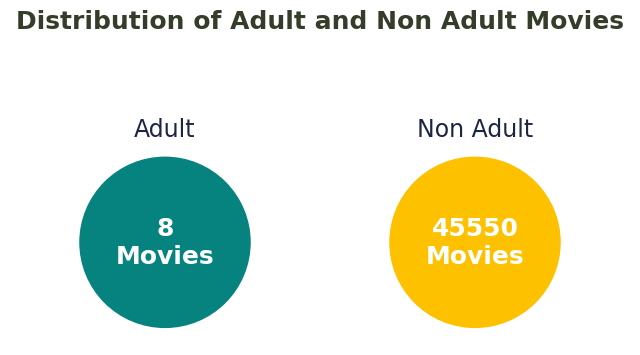

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

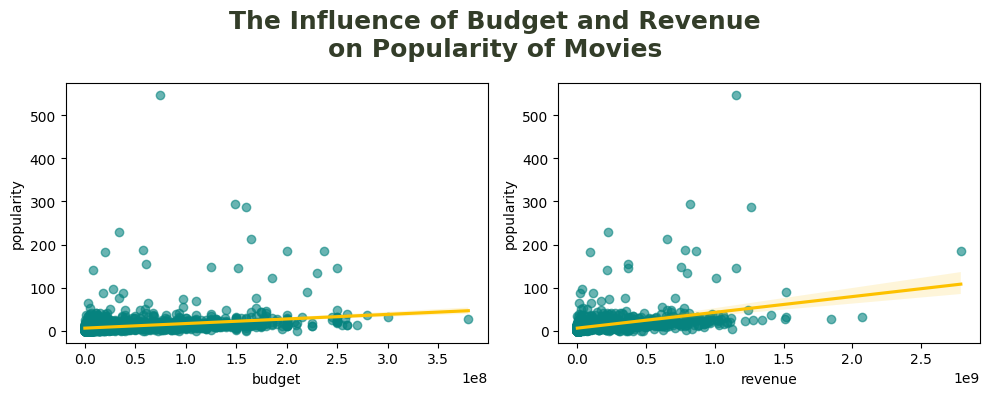

In [ ]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

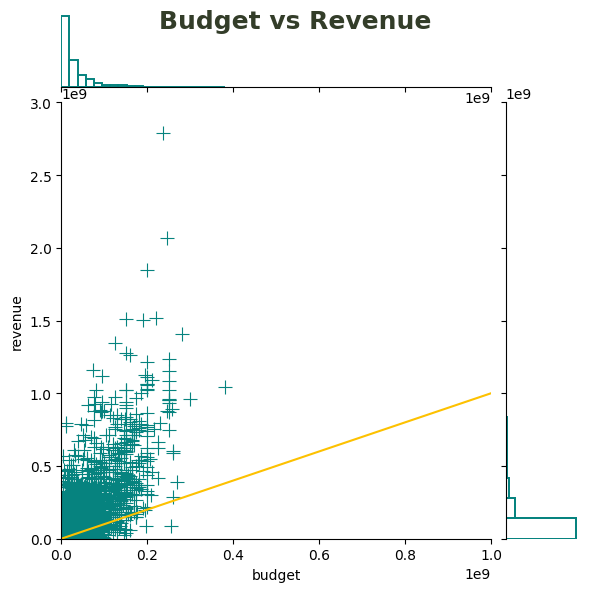

In [ ]:
ax = sns.jointplot(data=df[(df['budget'] != 0) & (df['revenue'] != 0)], x='budget', y='revenue',
                   marker="+", s=100, marginal_kws=dict(bins=20, fill=False), color='#06837f')
ax.fig.suptitle('Budget vs Revenue', fontsize=18, weight=600, color='#333d29')
ax.ax_joint.set_xlim(0, 1e9)
ax.ax_joint.set_ylim(0, 3e9)
ax.ax_joint.axline((1,1), slope=1, color='#fdc100')

(-1.25, 1.25, -1.25, 1.25)

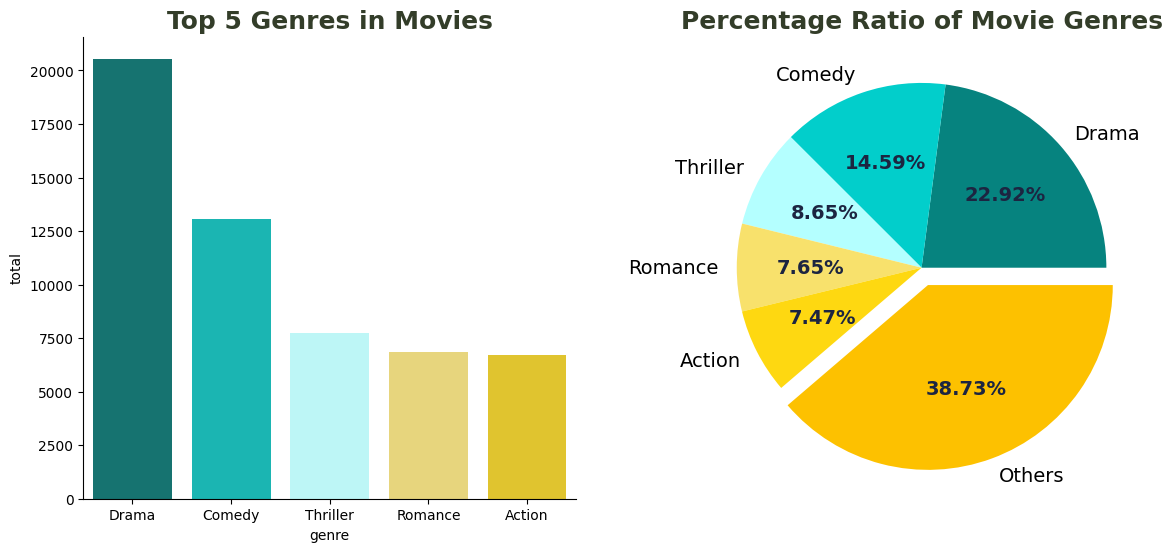

In [ ]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

Text(0.5, 1.0, 'Total Released Movie by Date')

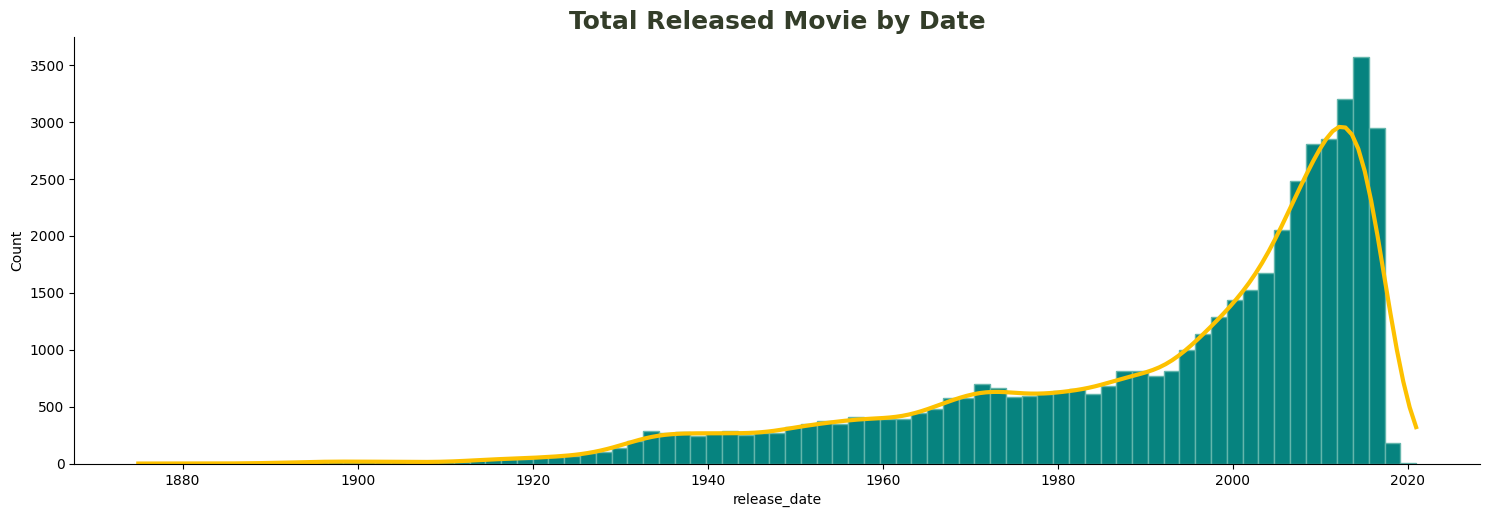

In [ ]:
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

In [ ]:
original_language_list = []
for i in df['original_language']:
    original_language_list.extend(i.split(', '))

spoken_languages_list = []
for i in df['spoken_languages']:
    if i != '':
        spoken_languages_list.extend(i.split(', '))

actors_list = []
for i in df['actors']:
    if i != '':
        actors_list.extend(i.split(', '))

crew_list = []
for i in df['crew']:
    if i != '':
        crew_list.extend(i.split(', '))

company_list = []
for i in df['production_companies']:
    if i != '':
        company_list.extend(i.split(', '))

country_list = []
for i in df['production_countries']:
    if i != '':
        country_list.extend(i.split(', '))

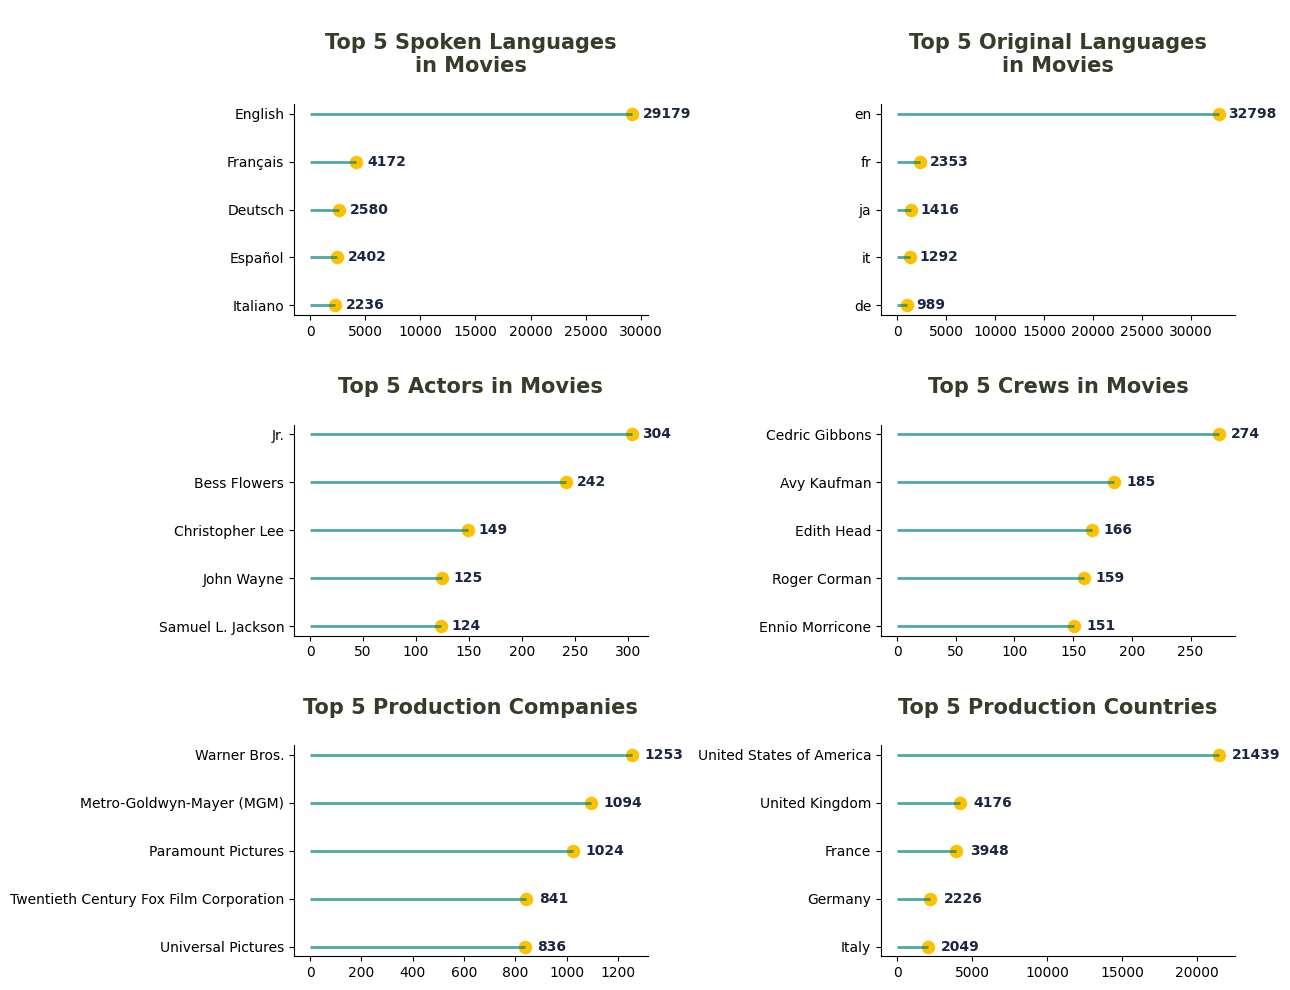

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 10))

# Spoken language plot
df_plot1 = pd.DataFrame(Counter(spoken_languages_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,0].hlines(y=df_plot1['language'], xmin=0, xmax=df_plot1['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=df_plot1['total'], y=df_plot1['language'], s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Spoken Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot1['total']):
    axes[0,0].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Original Language plot
df_plot2 = pd.DataFrame(Counter(original_language_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,1].hlines(y=df_plot2['language'], xmin=0, xmax=df_plot2['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=df_plot2['total'], y=df_plot2['language'], s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Original Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot2['total']):
    axes[0,1].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Actor plot
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['actor', 'total']).sort_values(by='total', ascending=True)
axes[1,0].hlines(y=df_plot3['actor'], xmin=0, xmax=df_plot3['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=df_plot3['total'], y=df_plot3['actor'], s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Actors in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot3['total']):
    axes[1,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Crew plot
df_plot4 = pd.DataFrame(Counter(crew_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[1,1].hlines(y=df_plot4['name'], xmin=0, xmax=df_plot4['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=df_plot4['total'], y=df_plot4['name'], s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Crews in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot4['total']):
    axes[1,1].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Company plot
df_plot5 = pd.DataFrame(Counter(company_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,0].hlines(y=df_plot5['name'], xmin=0, xmax=df_plot5['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,0].scatter(x=df_plot5['total'], y=df_plot5['name'], s = 75, color='#fdc100')
axes[2,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot5['total']):
    axes[2,0].text(value+50, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Country plot
df_plot6 = pd.DataFrame(Counter(country_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,1].hlines(y=df_plot6['name'], xmin=0, xmax=df_plot6['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,1].scatter(x=df_plot6['total'], y=df_plot6['name'], s = 75, color='#fdc100')
axes[2,1].set_title('\nTop 5 Production Countries\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot6['total']):
    axes[2,1].text(value+900, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

sns.despine()
plt.tight_layout()

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

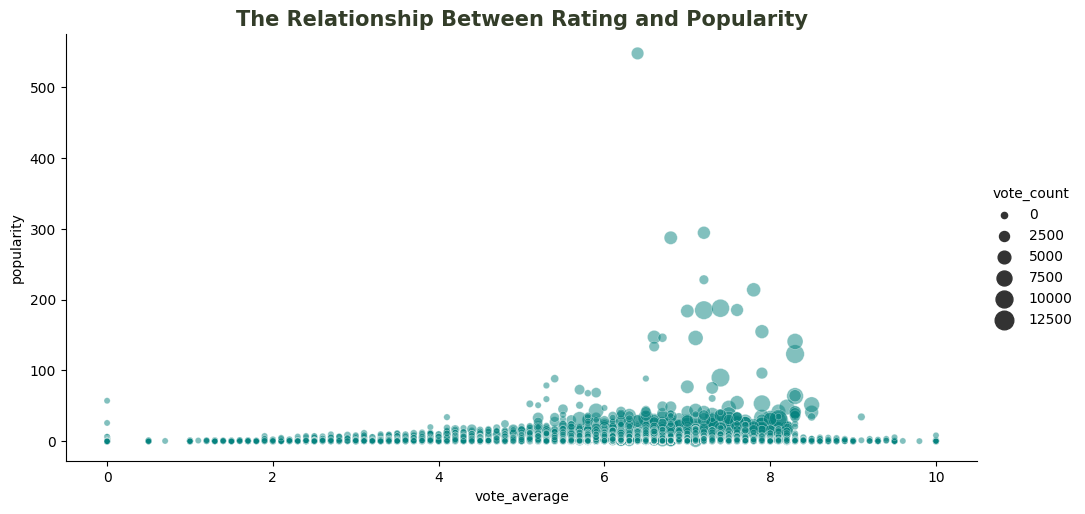

In [ ]:
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

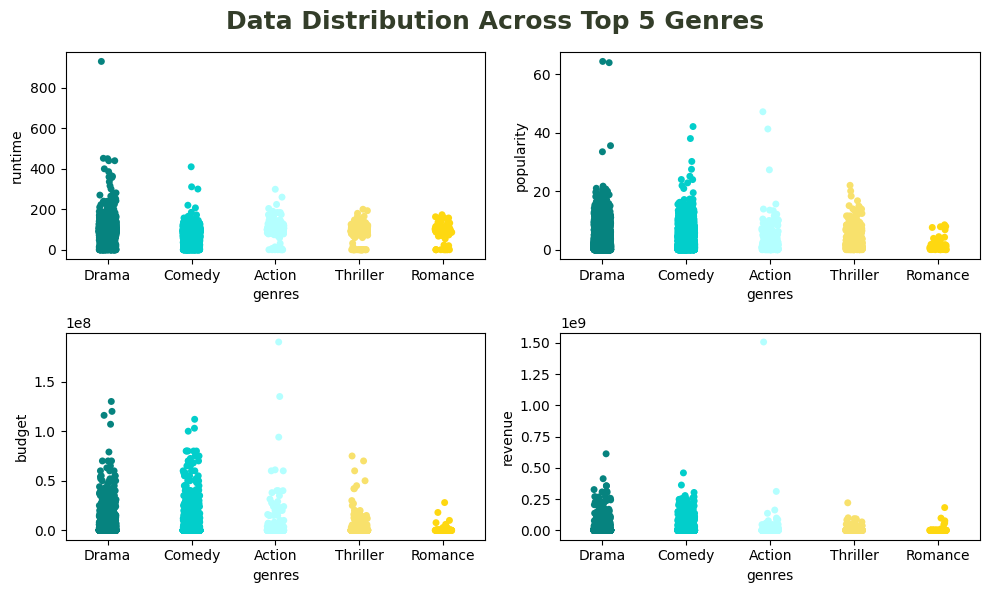

In [ ]:
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

<Axes: title={'center': 'Correlation of Movie Features\n'}>

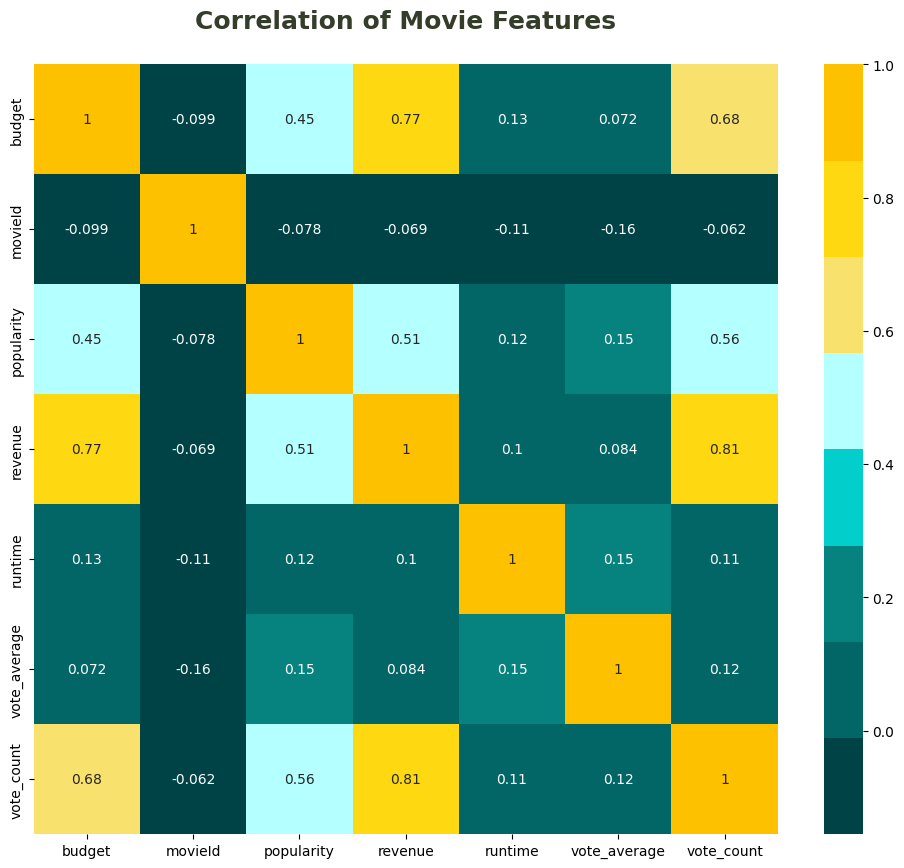

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(df.corr(), annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])